                             MSFT       AAPL
Rendement moyen annuel  -0.152729  -0.093623
Rendements cumulatifs   -0.144101  -0.095996
Volatilité quotidienne   0.005663   0.008006
Volatilité annualisée    0.089891   0.127093
Ratio de Sharpe         -1.699048  -0.736645
Bêta                     0.022524  -0.163159
Bêta haussier           -0.192035  -0.262953
Bêta baissier            0.255934  -0.403648
Drawndown maximal       -0.048810  -0.078070
Kurtosis                15.168969  12.109279
Skewness                -0.048810  -0.078070


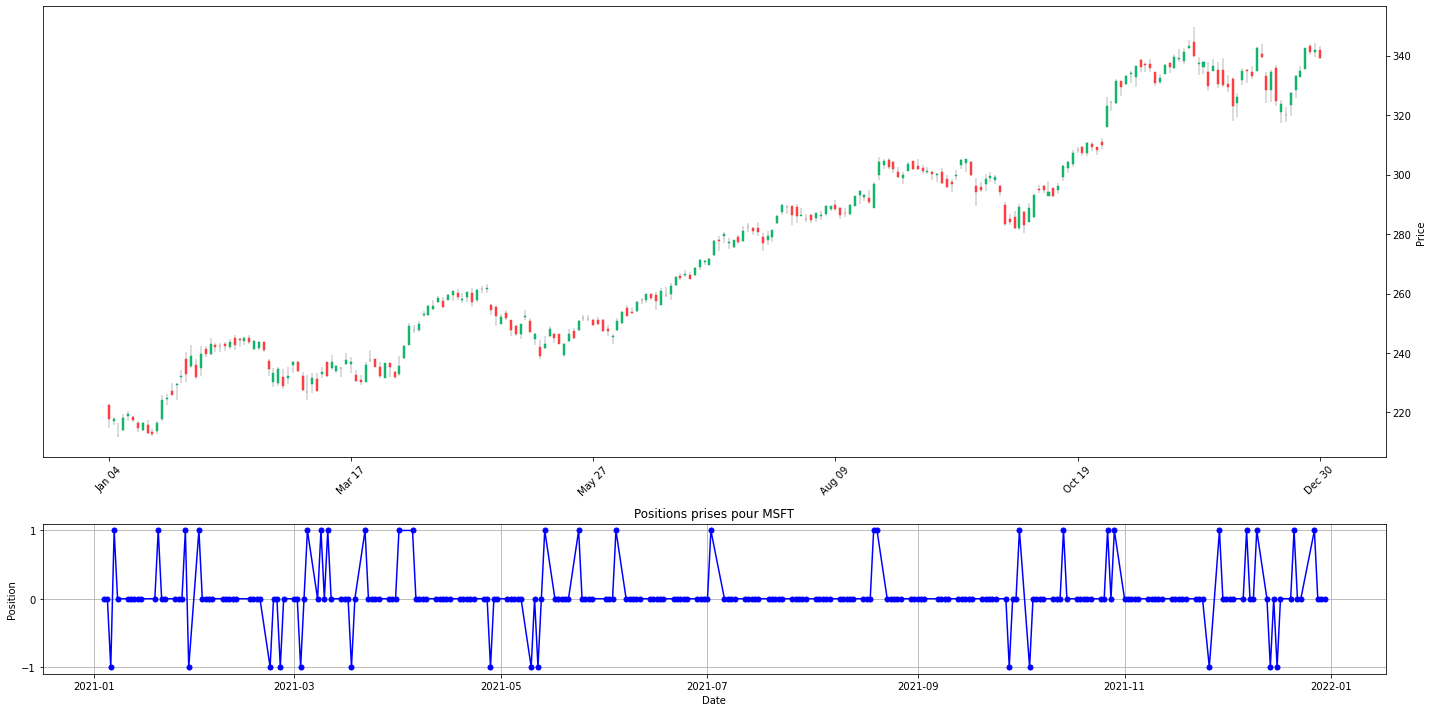

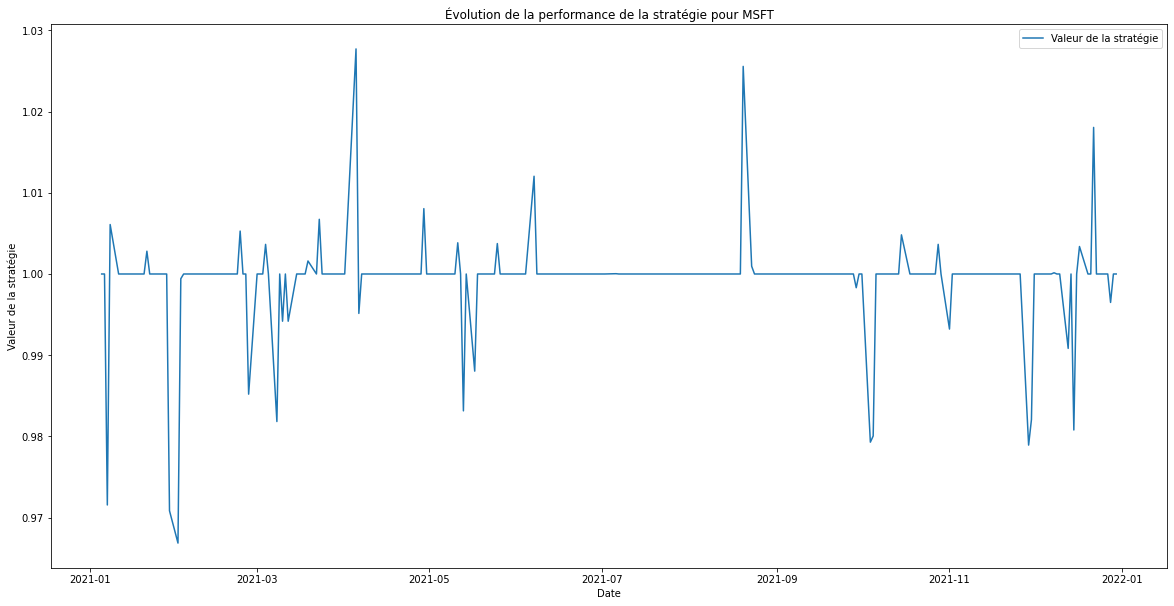

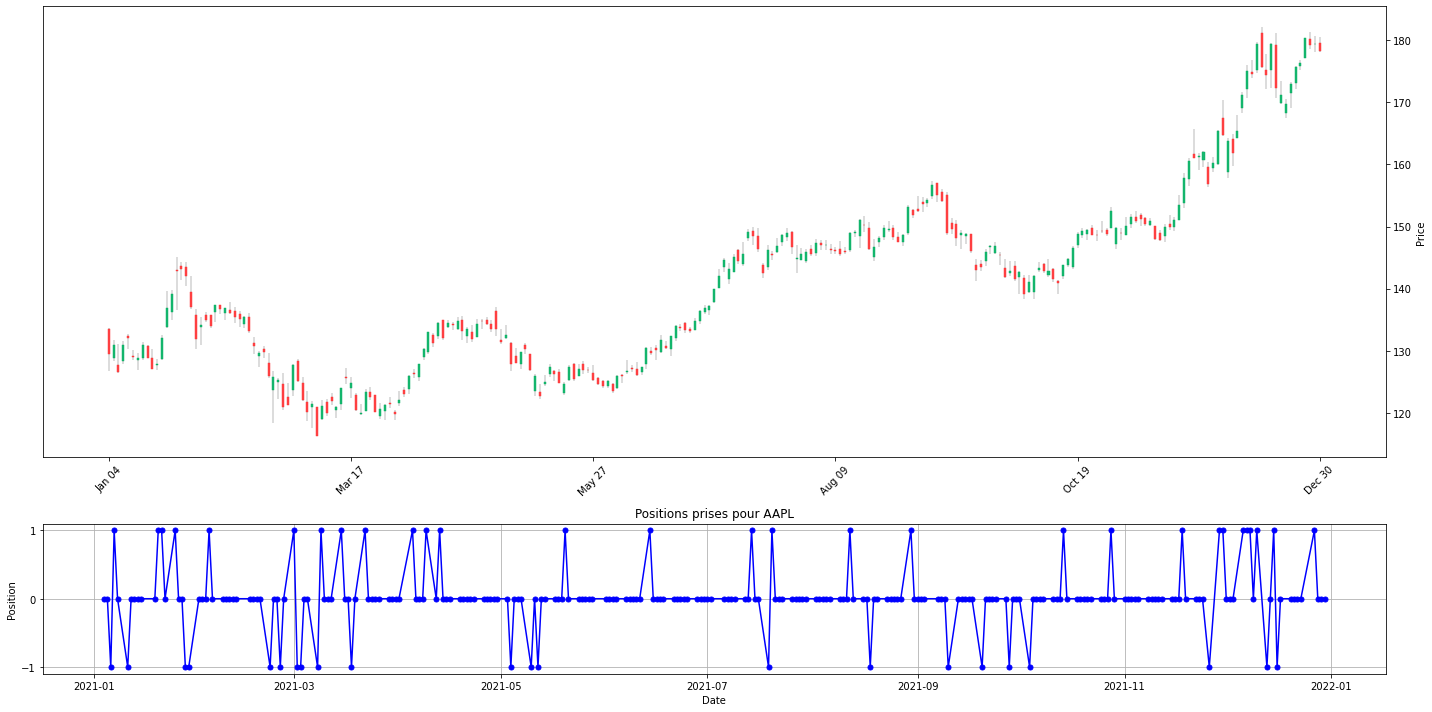

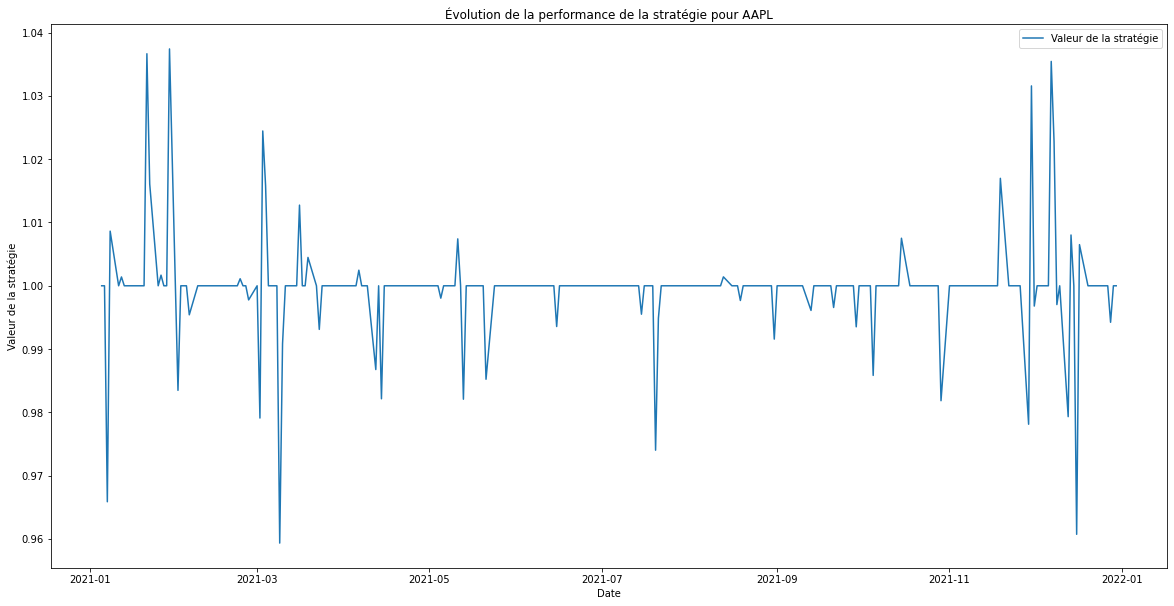

In [1]:
# Importation des bibliothèques
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import numpy as np
import os

class Backtester:
    # Initialisation de la classe
    def __init__(self, strategy):
        self.strategy = strategy
        
    # Compute : récupération, stockage des données et application de la stratégie
    def compute(self, symbols, start_date, end_date):
        # Déclaration des dictionnaires 
        self.df_market={}  # Dictionnaire pour les indices de marché
        self.symbols={} # Dictionnaire pour les symboles
        self.df={} # Dictionnaire pour les données des titres
        self.market_up = {} # Dictionnaire pour les indices de marché en hausse
        self.market_down = {} # Dictionnaire pour les indices de marché en baisse

        # Récupération et stockage local des données : Indices de marché
        #self.markets = ['^GSPC','^FCHI','^STOXX50E', 'ACWI']  # Symbole pour l'indice S&P 500, euro, CAC40, World
        self.market = '^GSPC'
        index_name = f"{self.market, start_date, end_date}_data.csv"
        if os.path.exists(index_name):
            market_data = pd.read_csv(index_name, index_col=0)
        else:
            market_data =yf.download(self.market, start=start_date, end=end_date)
            market_data.to_csv(index_name)
        self.df_market=pd.DataFrame(market_data)

        # Déterminer les rendements positives et négatives de l'indice
        self.df_market['positive'] = np.where(self.df_market['Close'].pct_change() > 0, self.df_market['Close'].pct_change(), np.nan)
        self.df_market['negative'] = np.where(self.df_market['Close'].pct_change() < 0, self.df_market['Close'].pct_change(), np.nan)
        self.market_up = self.df_market['Close'].pct_change() > 0
        self.market_down =  self.df_market['Close'].pct_change() < 0

        for symbol in symbols:
            # Récupération des symboles
            self.symbols[symbol] = symbol
            # Récupération et stockage local des données des titres
            file_name = f"{symbol, start_date, end_date}_data.csv"
            if os.path.exists(file_name):
                data = pd.read_csv(file_name, index_col=0)
            else:
                data = yf.download(symbol, start=start_date, end=end_date)
                data.to_csv(file_name)
            self.df[symbol] = pd.DataFrame(data)
            # Calcul des résultats pour la stratégie
            self.strategy(self.df[symbol])
        return 
       
    # Summary : indicateurs de performance de la stratégie
    def summary(self):
        # Déclaration des dictionnaires
        kurtosis = {}
        cumulative_strategy_return = {}
        volatility = {}
        annual_volatility = {}
        beta = {}
        beta_haussier={}
        beta_baissier={}
        max_drawdown = {}
        skewness = {}
        annual_strategy_return = {}
        resultats = {}
        sharpe_ratio={}
        
        
        for symbol in self.symbols:
            sous_liste = []
            
            # Rendements
            #Calcul des rendements du titres 
            self.df[symbol]['asset_returns']=self.df[symbol]['Close'].pct_change()
            
            #Calcul des rendements de la stratégie 
            self.df[symbol]['strategy_returns']=self.df[symbol]['asset_returns']*self.df[symbol]['Position'].shift(1)

            #Rendement moyen annuel 
            annual_strategy_return[symbol]=self.df[symbol]['strategy_returns'].mean()*252
            sous_liste.append(annual_strategy_return[symbol])

            #Calcul des rendements cumulatifs 
            cumulative_strategy_return[symbol]=(1+self.df[symbol]['strategy_returns'].dropna()).cumprod()-1
            self.df[symbol]['cumulative_strategy_return']=cumulative_strategy_return[symbol]
            sous_liste.append(cumulative_strategy_return[symbol].iloc[-1])


            # Volatilité
            # Volatilité quotidienne 
            volatility[symbol] =np.std(self.df[symbol]['strategy_returns'])
            sous_liste.append(volatility[symbol])
           
            # Volatilité annuelle 
            annual_volatility[symbol] = volatility[symbol]*np.sqrt(252)
            sous_liste.append(annual_volatility[symbol])

            # Ratio de Sharpe
            sharpe_ratio[symbol] = annual_strategy_return[symbol]/ annual_volatility[symbol]
            sous_liste.append(sharpe_ratio[symbol])

            # Affecter les rendements à de nouvelles variables
            action_returns = self.df[symbol]['strategy_returns'].dropna()
            marche_returns = self.df_market['Close'].pct_change().dropna()
            # Supprimer les dates qui ne sont pas communes aux deux séries
            common_dates = action_returns.index.intersection(marche_returns.index)
            action_returns = action_returns.loc[common_dates]
            marche_returns = marche_returns.loc[common_dates]

            beta[symbol]=(np.cov(marche_returns,action_returns)[0,1])/(np.var(marche_returns))
            sous_liste.append(beta[symbol])
            # Filtrer les rendements de l'actif et du marché pour inclure uniquement les périodes de hausse du marché
            
            self.df[symbol]['Market_up'] = self.df_market['positive']
            #print(self.df[symbol]['Market_up'])
            self.df[symbol]['Market_down'] = self.df_market['negative']
            
            self.df[symbol]['returns_up'] = self.df[symbol].loc[~self.df[symbol]['Market_up'].isna(), 'strategy_returns']
            self.df[symbol]['returns_down'] = self.df[symbol].loc[~self.df[symbol]['Market_down'].isna(), 'strategy_returns']
            
            # Bêta haussier
            var = (np.var(self.df[symbol]['Market_up'].dropna()))
            cov_haussier = (np.cov(self.df[symbol]['Market_up'].dropna(),self.df[symbol]['returns_up'].dropna())[0,1])
            cov_baissier = (np.cov(self.df[symbol]['Market_down'].dropna(),self.df[symbol]['returns_down'].dropna())[0,1])
            beta_haussier[symbol]= cov_haussier/var
            sous_liste.append(beta_haussier[symbol])
            
            # Bêta baissier
            beta_baissier[symbol]= cov_baissier/var
            sous_liste.append(beta_baissier[symbol])
            # Drawdown maximal
            self.df[symbol]['drawdowns'] = self.df[symbol]['strategy_returns'] - self.df[symbol]['strategy_returns'].cummax()
            max_drawdown[symbol] = self.df[symbol]['drawdowns'].min()
            sous_liste.append(max_drawdown[symbol])

            # Kurtosis
            kurtosis[symbol] = (self.df[symbol]['strategy_returns'].dropna()).kurtosis()
            sous_liste.append(kurtosis[symbol])
            #print(kurtosis[symbol])

            # Skewness
            skewness[symbol] = self.df[symbol]['drawdowns'].min()
            sous_liste.append(skewness[symbol])

            #Dictionnaire resultats
            resultats[symbol] = sous_liste
           
        
        etiquettes = ['Rendement moyen annuel','Rendements cumulatifs', 'Volatilité quotidienne','Volatilité annualisée', 'Ratio de Sharpe','Bêta','Bêta haussier','Bêta baissier','Drawndown maximal','Kurtosis','Skewness']
        dfr = pd.DataFrame(resultats)
        dfr = dfr.set_index(pd.Index(etiquettes))
         
        return dfr
     
    # Plot : Visualisation des résultats
    def plot(self):
        #Graphique des positions + cours du prix
        # Calculer la valeur de la stratégie en base 100
        for symbol in self.symbols:
            self.df[symbol]['strategy_value'] = (1 + self.df[symbol]['strategy_returns'])

        # Créer une nouvelle figure avec deux sous-graphiques
            fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]})

        #Tracer le graphique de chandelier japonais du cours de l'action
            # Convertir l'index en datetime
            self.df[symbol].index = pd.to_datetime(self.df[symbol].index)
            # Créer le graphique
            mpf.plot(self.df[symbol], type='candle', volume=False, style='yahoo', ax=axs[0])
            

        #Tracer le graphique pour la prise de position 
            # Créer un nouveau graphique pour les positions prises
            # Tracer les positions sur le deuxième sous-graphique
            axs[1].plot(self.df[symbol].index, self.df[symbol]['Position'], marker='o', linestyle='-', color='b', markersize=5)
            axs[1].set_title(f"Positions prises pour {symbol}")
            axs[1].set_xlabel('Date')
            axs[1].set_ylabel('Position')
            axs[1].set_yticks([-1, 0, 1])
            
            axs[1].grid(True)
        
            # Ajuster l'espacement entre les sous-graphiques
            plt.tight_layout()
        
            # Afficher le graphique combiné
            plt.show()

        

        # Tracer graphiquement l'évolution de la valeur de la stratégie
            plt.figure(figsize=(20, 10))
            plt.plot(self.df[symbol]['strategy_value'], label='Valeur de la stratégie')
            plt.title(f"Évolution de la performance de la stratégie pour {symbol}")
            plt.xlabel('Date')
            plt.ylabel('Valeur de la stratégie')
            plt.legend()
            plt.show()


        return

# Exemple de stratégie
def mastrategie(data):
    # Exemple de stratégie : prendre des positions basées sur le signe de la variation de prix
    # entre les deux derniers jours
    positions = [0]  # La première journée n'a pas de position
    for i in range(1, len(data)):
        price_change = (data['Close'].iloc[i] - data['Close'].iloc[i-1]) / data['Close'].iloc[i-1]
        if price_change > 0.02:
            positions.append(1)  # Acheter partiellement
        elif price_change < -0.02:
            positions.append(-1)  # Vendre partiellement
        else:
            positions.append(0)  # Ne pas prendre de position
    
    # Ajouter la colonne "Position" au DataFrame
    data['Position'] = positions
    return data['Position']

def simple_strategy(data):
    # Exemple de stratégie simple : achat lorsque la moyenne mobile sur 50 jours est supérieure à la moyenne mobile sur 200 jours, et vente dans le cas contraire
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()
    data['Position'] = 0
    data.loc[data['50_MA'] > data['200_MA'], 'Position'] = 1  # Achat
    data.loc[data['50_MA'] < data['200_MA'], 'Position'] = -1  # Vente
    return data['Position']

# Exemple d'utilisation du backtester avec la stratégie simple
Backteste = Backtester(strategy=mastrategie)
Backteste.compute(["MSFT", "AAPL"], "2021-01-01","2021-12-31")
print(Backteste.summary())
Backteste.plot()
